## ***ETL Pipeline With Banggood.com***
- part 01 
- 

In [31]:
import os
import time
import random
import pandas as pd
from tqdm import tqdm

from selenium import webdriver
from selenium.common.exceptions import WebDriverException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager


# ---------------- CONFIG ----------------
CATEGORIES = {
    "phones": "https://www.banggood.com/search/phones.html?page={}",
    "smartwatches": "https://www.banggood.com/search/smartwatches.html?page={}",
    "laptops": "https://www.banggood.com/search/laptops.html?page={}",
    "rc_drones": "https://www.banggood.com/search/rc-drones.html?page={}",
    "home_appliances": "https://www.banggood.com/search/home-appliances.html?page={}"
}

OUTPUT_DIR = "data/raw"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MAX_PAGES = 5
RETRY_LIMIT = 5      # 🔥 NEW FIX


# ---------------- DRIVER ----------------
def get_driver():
    options = Options()

    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("window-size=1920,1080")

    # 🔥 Best working user-agent for Banggood
    options.add_argument(
        "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128 Safari/537.36"
    )

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )

    driver.set_page_load_timeout(60)    # 🔥 very important
    return driver


# -------------- SAFE PAGE LOADER ----------------
def safe_get(driver, url):
    for attempt in range(RETRY_LIMIT):
        try:
            driver.get(url)
            return True
        except WebDriverException:
            print(f"⚠ DNS failed → Retrying ({attempt+1}/{RETRY_LIMIT}) ...")
            time.sleep(3)

    print(f"❌ FAILED to load page after {RETRY_LIMIT} retries: {url}")
    return False


# ---------------- SCRAPER ----------------
def scrape_category(category_name, url_template):
    driver = get_driver()
    all_products = []

    print(f"\n🔵 Scraping: {category_name}")

    for page in tqdm(range(1, MAX_PAGES + 1), desc=f"{category_name} pages"):

        # Page URL
        url = url_template.format(page)

        # Retry loader
        if not safe_get(driver, url):
            continue

        time.sleep(4)

        # Scroll full page
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        items = driver.find_elements(By.CSS_SELECTOR, "div.p-wrap")

        # If blocked or no items → retry same page
        if len(items) == 0:
            print(f"⚠ No items found on page {page}, retrying...")
            time.sleep(3)
            if not safe_get(driver, url):
                continue
            items = driver.find_elements(By.CSS_SELECTOR, "div.p-wrap")

        # Still no items? then stop category.
        if len(items) == 0:
            print("⚠ Skipping category — selectors not found.")
            break

        # Extract data
        for item in items:
            try:
                title_elem = item.find_element(By.CSS_SELECTOR, "a.title")
                name = title_elem.text.strip()
                product_url = title_elem.get_attribute("href")
            except:
                name = None
                product_url = None

            try:
                price = item.find_element(By.CSS_SELECTOR, "span.price").text.strip()
            except:
                price = None

            try:
                old_price = item.find_element(By.CSS_SELECTOR, "span.price-old").text.strip()
            except:
                old_price = None

            try:
                discount = item.find_element(By.CSS_SELECTOR, "span.price-discount").text.strip()
            except:
                discount = None

            try:
                reviews = item.find_element(By.CSS_SELECTOR, "a.review").text.strip()
            except:
                reviews = None

            try:
                rating = item.find_element(By.CSS_SELECTOR, "span.review-text").text.strip()
            except:
                rating = None

            all_products.append({
                "category": category_name,
                "product_name": name,
                "product_url": product_url,
                "price": price,
                "old_price": old_price,
                "discount": discount,
                "reviews": reviews,
                "rating": rating
            })

        time.sleep(random.uniform(2, 4))

    driver.quit()

    # Save CSV
    df = pd.DataFrame(all_products)
    output_file = os.path.join(OUTPUT_DIR, f"{category_name}.csv")
    df.to_csv(output_file, index=False)

    print(f"✅ Saved {len(all_products)} products → {output_file}")


# ---------------- MAIN ----------------
def main():
    for category, url in CATEGORIES.items():
        scrape_category(category, url)


if __name__ == "__main__":
    main()



🔵 Scraping: phones


phones pages: 100%|██████████| 5/5 [02:51<00:00, 34.24s/it]


✅ Saved 300 products → data/raw\phones.csv

🔵 Scraping: smartwatches


smartwatches pages:  20%|██        | 1/5 [00:30<02:01, 30.38s/it]

⚠ No items found on page 2, retrying...


smartwatches pages:  20%|██        | 1/5 [00:46<03:05, 46.30s/it]

⚠ Skipping category — selectors not found.


✅ Saved 29 products → data/raw\smartwatches.csv

🔵 Scraping: laptops


laptops pages:  80%|████████  | 4/5 [03:01<00:45, 45.80s/it]

⚠ No items found on page 5, retrying...


laptops pages:  80%|████████  | 4/5 [03:35<00:53, 53.86s/it]

⚠ Skipping category — selectors not found.


✅ Saved 237 products → data/raw\laptops.csv

🔵 Scraping: rc_drones


rc_drones pages:  40%|████      | 2/5 [01:20<01:57, 39.09s/it]

⚠ No items found on page 3, retrying...


rc_drones pages:  40%|████      | 2/5 [01:38<02:27, 49.21s/it]

⚠ Skipping category — selectors not found.


✅ Saved 117 products → data/raw\rc_drones.csv

🔵 Scraping: home_appliances


home_appliances pages:  20%|██        | 1/5 [00:35<02:20, 35.11s/it]

⚠ No items found on page 2, retrying...


home_appliances pages:  20%|██        | 1/5 [00:58<03:52, 58.11s/it]

⚠ Skipping category — selectors not found.


✅ Saved 25 products → data/raw\home_appliances.csv


## ***Part 2: Data Cleaning & Transformation***

In [48]:
import pandas as pd
import numpy as np
import os
import re # Regular Expression library for cleaning text

### ***Step 2: File Paths Define (Debugged) ---***

In [51]:
import pandas as pd
import os

# --- Step 2: File Paths Define Karna aur Data Load Karna (Debugged) ---

# *************************************************************************
# ZAROOR BADLEIN: Apne actual directory path se. Double-check karein.
# *************************************************************************
folder_path = r'E:\cde\CDE_HACATHON\data\raw' 

# File Paths definition
file_paths = {
    'Home Appliances': folder_path + r'\home_appliances.csv',
    'Laptops': folder_path + r'\laptops.csv',
    'Smartwatches': folder_path + r'\smartwatches.csv',
    'RC Drones': folder_path + r'\rc_drones.csv',
    'Smartwatches_Raw': folder_path + r'\smartwatches_raw.csv' 
}

# Sabhi DataFrames ko store karne ke liye list
all_dfs = []
successful_loads = 0

print(f"Checking folder path: {folder_path}\n")

# Har file ko load karna aur Category column add karna
for category, path in file_paths.items():
    print(f"Attempting to load: {category} from {path}")
    
    # 1. Check if the file exists physically
    if not os.path.exists(path):
        print(f"🔴 ERROR: File not found at path: {path}")
        continue # Skip to the next file
        
    try:
        # pd.read_csv mein robust settings use karein
        df = pd.read_csv(
            path, 
            encoding='utf-8', 
            on_bad_lines='skip', 
            index_col=None # Index column ko avoid karein
        )
        
        if df.empty:
            print(f"🟠 WARNING: {category} file is empty (0 rows). Skipping.")
            continue # Skip empty files
        
        # Remove the '_Raw' suffix for consistent category naming
        if '_Raw' in category:
             category = category.replace('_Raw', '')
             
        df['Category'] = category 
        all_dfs.append(df)
        successful_loads += 1
        print(f"🟢 SUCCESS: Loaded {category} with {len(df)} rows.")
        
    except pd.errors.EmptyDataError:
        print(f"🟠 WARNING: {category} file exists but contains no columns/data. Skipping.")
    except Exception as e:
        print(f"🔴 CRITICAL ERROR loading {path}: {type(e).__name__} - {e}")


# --- Concatenation (Only if data was loaded) ---
if successful_loads > 0:
    print("\n--- Concatenation Result ---")
    df_master = pd.concat(all_dfs, ignore_index=True)
    print(f"✅ CONCATENATION SUCCESSFUL. Total combined rows: {len(df_master)}")
    print("Columns before cleaning:", df_master.columns.tolist())
    
    # Ab aap yahan se aage ke Steps 3, 4, aur 5 ko run kar sakte hain.
    # Upar wala code chalane ke baad, df_master variable mein data aa chuka hoga.
    
else:
    # Original error ka source
    print("\n❌ FINAL ERROR: No successful loads. 'all_dfs' is empty.")
    print("Please check your 'folder_path' and ensure the CSV files contain data.")
    # Hum yahan pd.concat ko nahi chalayenge, isliye ValueError nahi aayega

Checking folder path: E:\cde\CDE_HACATHON\data\raw

Attempting to load: Home Appliances from E:\cde\CDE_HACATHON\data\raw\home_appliances.csv
🟢 SUCCESS: Loaded Home Appliances with 25 rows.
Attempting to load: Laptops from E:\cde\CDE_HACATHON\data\raw\laptops.csv
🟢 SUCCESS: Loaded Laptops with 237 rows.
Attempting to load: Smartwatches from E:\cde\CDE_HACATHON\data\raw\smartwatches.csv
🟢 SUCCESS: Loaded Smartwatches with 29 rows.
Attempting to load: RC Drones from E:\cde\CDE_HACATHON\data\raw\rc_drones.csv
🟢 SUCCESS: Loaded RC Drones with 117 rows.
Attempting to load: Smartwatches_Raw from E:\cde\CDE_HACATHON\data\raw\smartwatches_raw.csv
🟢 SUCCESS: Loaded Smartwatches with 29 rows.

--- Concatenation Result ---
✅ CONCATENATION SUCCESSFUL. Total combined rows: 437
Columns before cleaning: ['category', 'product_name', 'product_url', 'price', 'old_price', 'discount', 'reviews', 'rating', 'Category']


## ***Step 3: Data Cleaning (Consistency Fix)***

In [55]:
import numpy as np
import pandas as pd # Ensure pandas is imported if you are running this cell separately

def clean_banggood_data(df):
    """Columns ko rename, clean aur type convert karta hai."""
    
    # 1. Dynamic Column Renaming aur Check
    # Column names ko lowercase mein badal dein takhi case-sensitive errors na aaein
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
    
    # Common name variations check karna
    price_cols = [col for col in df.columns if 'price' in col]
    rating_cols = [col for col in df.columns if 'rating' in col]
    review_cols = [col for col in df.columns if 'review' in col]
    
    # --- Price Column Handling ---
    if price_cols:
        # **FIX 1: RENAME TO LOWERCASE 'price'**
        df.rename(columns={price_cols[0]: 'price'}, inplace=True)
        print(f"-> Renamed '{price_cols[0]}' to 'price'.")
    else:
        # Agar 'price' nahi mila, toh processing rokna zaroori hai
        raise KeyError("🔴 FATAL: Price column not found in any common format.")
        
    # --- Reviews Count Column Handling ---
    if review_cols:
        # **FIX 2: RENAME TO LOWERCASE 'reviews_count_raw'**
        df.rename(columns={review_cols[0]: 'reviews_count_raw'}, inplace=True)
        print(f"-> Renamed '{review_cols[0]}' to 'reviews_count_raw'.")
    else:
        print("🟠 WARNING: Reviews Count column not found. Setting reviews_count to 0.")
        df['reviews_count'] = 0
        df['reviews_count_raw'] = 0

    # --- Rating Column Handling ---
    if rating_cols:
        # **FIX 3: RENAME TO LOWERCASE 'rating'**
        df.rename(columns={rating_cols[0]: 'rating'}, inplace=True)
        print(f"-> Renamed '{rating_cols[0]}' to 'rating'.")
    else:
        print("🟠 WARNING: Rating column not found. Setting rating to NaN for median imputation.")
        df['rating'] = np.nan
    
    
    # --- Actual Cleaning and Type Conversion ---
    
    # 1. Price Cleaning (Now using lowercase 'price')
    print("-> Cleaning price...")
    df['price'] = df['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['price'] = pd.to_numeric(df['price'], errors='coerce') 
    
    # 2. Rating Cleaning (Now using lowercase 'rating')
    if 'rating' in df.columns:
        print("-> Cleaning rating...")
        df['rating'] = df['rating'].astype(str).str.extract(r'(\d+\.?\d*)', expand=False) 
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    
    # 3. Reviews Count Cleaning (Now using lowercase 'reviews_count_raw')
    if 'reviews_count_raw' in df.columns:
        print("-> Cleaning reviews_count...")
        df['reviews_count'] = df['reviews_count_raw'].astype(str).str.extract(r'(\d+)', expand=False)
        df['reviews_count'] = pd.to_numeric(df['reviews_count'], errors='coerce').fillna(0).astype('Int64')
        df = df.drop(columns=['reviews_count_raw'], errors='ignore')
    
    # Ensure 'reviews_count' exists for consistency, even if it was missing.
    if 'reviews_count' not in df.columns:
        df['reviews_count'] = 0
        
    return df

# Function call will now work correctly because the columns are consistently lowercase
df_cleaned = clean_banggood_data(df_master.copy())
print("\nStep 3 Complete. Data Types after basic cleaning:")
# This line is now correct because 'price', 'rating', 'reviews_count' are all lowercase
print(df_cleaned[['price', 'rating', 'reviews_count', 'category']].dtypes)

-> Renamed 'price' to 'price'.
-> Renamed 'reviews' to 'reviews_count_raw'.
-> Renamed 'rating' to 'rating'.
-> Cleaning price...
-> Cleaning rating...
-> Cleaning reviews_count...

Step 3 Complete. Data Types after basic cleaning:
price            float64
rating           float64
reviews_count      Int64
category          object
category          object
dtype: object



## ***Step 4 & 5 Code (Integrated Fix)***

In [57]:
import numpy as np
import pandas as pd

# --- FIX: Duplicate Column Removal (Run this before calling the function) ---
# Agar 'category' column duplicate hai, toh pehle instance ko rakhenge
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated(keep='first')] 
print(f"🟢 FIX APPLIED: Duplicate columns removed. Current columns: {df_cleaned.columns.tolist()}")
# --------------------------------------------------------------------------


def create_derived_features_and_handle_missing(df):
    """Derived features banata hai aur missing values handle karta hai."""
    
    # --- 1. Derived Feature: Normalized_Price (Z-Score) ---
    print("\n-> Creating Normalized_Price (Z-Score)...")
    
    # Groupby will now work as 'category' is unique
    stats = df.groupby('category')['price'].agg(['mean', 'std'])
    
    def calculate_zscore(row):
        category = row['category']
        price = row['price']
        
        std_val = stats.loc[category, 'std']
        if pd.isna(std_val) or std_val == 0:
            return 0.0
        return (price - stats.loc[category, 'mean']) / std_val

    df['normalized_price'] = df.apply(calculate_zscore, axis=1)

    # --- 2. Derived Feature: Review_Density ---
    print("-> Creating Review_Density (Quality & Popularity Metric)...")
    df['review_density'] = df['rating'] * np.log1p(df['reviews_count'])
    
    # --- 3. Missing Value Handling ---
    print("-> Handling Missing Values...")

    initial_rows = len(df)
    df = df.dropna(subset=['price'])
    
    df['rating'] = df.groupby('category')['rating'].transform(
        lambda x: x.fillna(x.median())
    )

    df['rating'] = df['rating'].fillna(0.0)
    
    df['reviews_count'] = df['reviews_count'].astype('Int64')

    print(f"Rows dropped (due to missing price): {initial_rows - len(df)}")
    print(f"Final dataset size: {len(df)} rows")
    
    return df

# df_cleaned ko use karte hue function call karein
# Ensure 'df_cleaned' exists and contains data from Step 3
df_final = create_derived_features_and_handle_missing(df_cleaned.copy())

print("\n--- ✅ Part 2 Complete: Final Cleaned Data Snapshot ---")
df_final.info()
print("\nFirst 5 rows of the Cleaned and Transformed Data:")
print(df_final[['category', 'price', 'rating', 'reviews_count', 'normalized_price', 'review_density']].head())

🟢 FIX APPLIED: Duplicate columns removed. Current columns: ['category', 'product_name', 'product_url', 'price', 'old_price', 'discount', 'rating', 'reviews_count']

-> Creating Normalized_Price (Z-Score)...
-> Creating Review_Density (Quality & Popularity Metric)...
-> Handling Missing Values...
Rows dropped (due to missing price): 0
Final dataset size: 437 rows

--- ✅ Part 2 Complete: Final Cleaned Data Snapshot ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   category          437 non-null    object 
 1   product_name      437 non-null    object 
 2   product_url       437 non-null    object 
 3   price             437 non-null    float64
 4   old_price         336 non-null    object 
 5   discount          336 non-null    object 
 6   rating            437 non-null    float64
 7   reviews_count     437 non-null    Int64  
 8  

# ***Part 3: Python Exploratory Analysis (Minimum 5 Analyses)***

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Yeh line ensure karegi ki graphs Jupyter/IPython mein dikhein
%matplotlib inline 

# Style set kar lete hain takay graphs acche dikhein
sns.set_style("whitegrid")

### ***Analysis 1: Price Distribution per Category (Histogram/Box Plot)***

--- 1. Price Distribution per Category ---


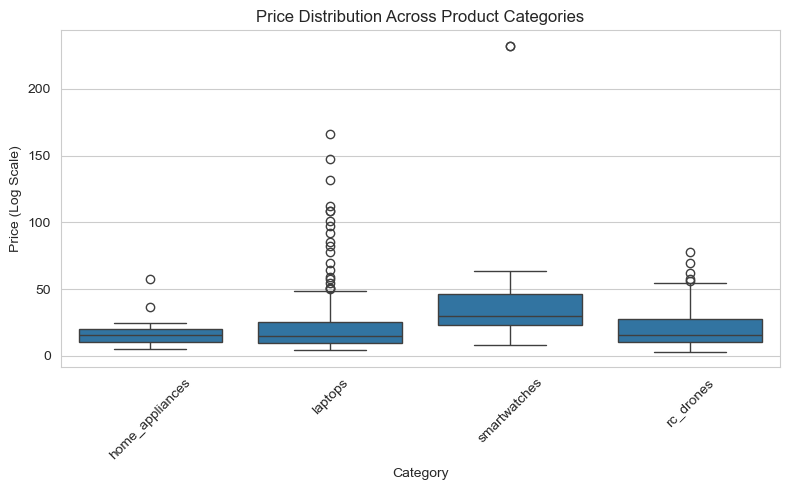


Median Price per Category (for reference):
 category
smartwatches       29.41
rc_drones          15.48
home_appliances    15.32
laptops            14.70
Name: price, dtype: float64


In [67]:
## 1. Price Distribution per Category
print("--- 1. Price Distribution per Category ---")

# Category-wise Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='category', y='price', data=df_final)
plt.title('Price Distribution Across Product Categories')
plt.xlabel('Category')
plt.ylabel('Price (Log Scale)')
# Hum y-axis ko log scale mein rakhenge agar prices ki range bahut zyada ho
# (Jaise Laptops Rs 50,000, aur accessories Rs 500)
# Agar aapke data mein log scale zaroori nahi hai, toh yeh line hata sakte hain:
# plt.yscale('log') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insight nikalna:
category_median_prices = df_final.groupby('category')['price'].median().sort_values(ascending=False)
print("\nMedian Price per Category (for reference):\n", category_median_prices)

### ***Analysis 2: Rating vs Price Correlation (Scatter Plot)***


--- 2. Rating vs Price Correlation ---
Correlation between Price and Rating: -0.11


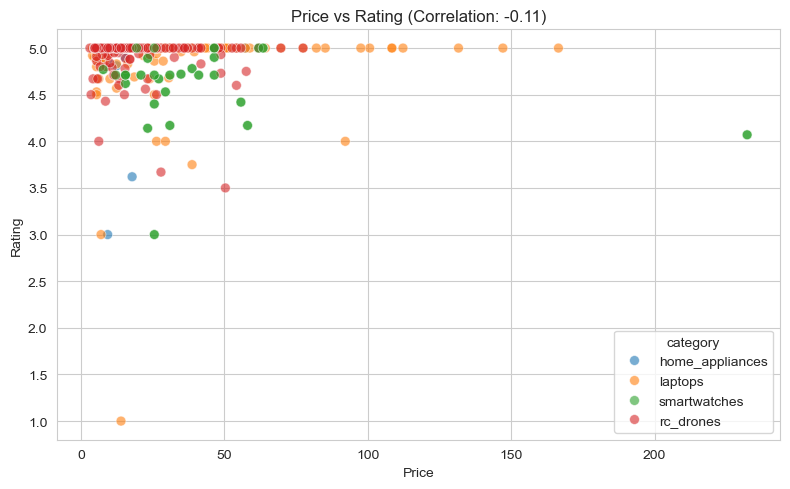

In [66]:
## 2. Rating vs Price Correlation
print("\n--- 2. Rating vs Price Correlation ---")

# Correlation coefficient calculate karna
correlation = df_final['price'].corr(df_final['rating'])
print(f"Correlation between Price and Rating: {correlation:.2f}")

# Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='price', y='rating', data=df_final, hue='category', alpha=0.6, s=50)
plt.title(f'Price vs Rating (Correlation: {correlation:.2f})')
plt.xlabel('Price')
plt.ylabel('Rating')
# Price ko log scale karna correlation ko behtar samajhne mein madad kar sakta hai
# plt.xscale('log') 
plt.tight_layout()
plt.show()

### ***Analysis 3: Top Reviewed Products (Bar Chart)***


--- 3. Top Reviewed Products (Overall) ---


C:\Users\Hp Probook\AppData\Local\Temp\ipykernel_13720\2070790800.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


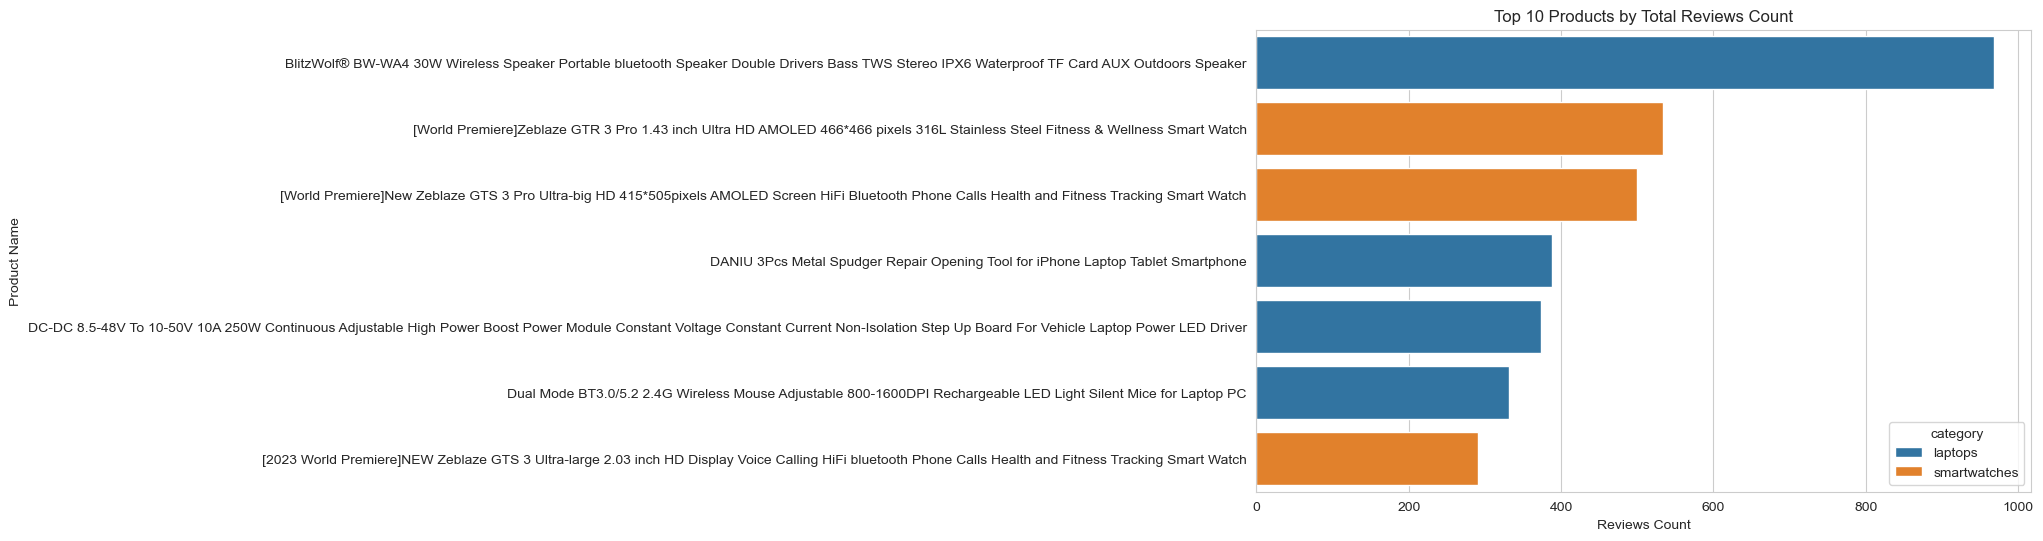


Top 5 Products by Reviews:
                                          product_name      category  \
31   BlitzWolf® BW-WA4 30W Wireless Speaker Portabl...       laptops   
409  [World Premiere]Zeblaze GTR 3 Pro 1.43 inch Ul...  smartwatches   
263  [World Premiere]Zeblaze GTR 3 Pro 1.43 inch Ul...  smartwatches   
408  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...  smartwatches   
262  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...  smartwatches   
146  DANIU 3Pcs Metal Spudger Repair Opening Tool f...       laptops   
53   DC-DC 8.5-48V To 10-50V 10A 250W Continuous Ad...       laptops   
39   Dual Mode BT3.0/5.2 2.4G Wireless Mouse Adjust...       laptops   
264  [2023 World Premiere]NEW Zeblaze GTS 3 Ultra-l...  smartwatches   
410  [2023 World Premiere]NEW Zeblaze GTS 3 Ultra-l...  smartwatches   

     reviews_count  
31             969  
409            534  
263            534  
408            500  
262            500  
146            388  
53             374  
39         

In [65]:
## 3. Top Reviewed Products
print("\n--- 3. Top Reviewed Products (Overall) ---")

# Top 10 products ko Reviews_Count ke hisaab se sort karna
top_reviewed = df_final.sort_values(by='reviews_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='reviews_count', y='product_name', data=top_reviewed, hue='category', dodge=False)
plt.title('Top 10 Products by Total Reviews Count')
plt.xlabel('Reviews Count')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

print("\nTop 5 Products by Reviews:")
print(top_reviewed[['product_name', 'category', 'reviews_count']])

### ***Analysis 4: Best Value Metric per Category (Review Density)***


--- 4. Top Value Products (Highest Review Density) per Category ---
           category                                       product_name  price  \
0   home_appliances  Adjustable USB Rechargeable Soldering Iron Kit...   7.73   
1   home_appliances  Comfook Electric Coffee Grinder Cafe Automatic...  15.32   
2   home_appliances  Moes WiFi RF IR Universal Remote Controller RF...  12.38   
3           laptops  BlitzWolf® BW-WA4 30W Wireless Speaker Portabl...  23.99   
4           laptops  DANIU 3Pcs Metal Spudger Repair Opening Tool f...   7.73   
5           laptops  DC-DC 8.5-48V To 10-50V 10A 250W Continuous Ad...   5.41   
6         rc_drones  Racerstar BA2216 880KV/1100KV/1250KV/1400KV/18...  10.06   
7         rc_drones  Geprc GEP M10 Series GPS Module 3.3-5V M10 Chi...  15.48   
8         rc_drones  DarwinFPV 1504 2300KV 4-6S / 3600KV 4S Brushle...   8.72   
9      smartwatches  [World Premiere]New Zeblaze GTS 3 Pro Ultra-bi...   7.73   
10     smartwatches  [World Premiere]New

C:\Users\Hp Probook\AppData\Local\Temp\ipykernel_13720\2554037944.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_value_products = df_final.groupby('category').apply(get_top_n_value).reset_index(drop=True)
C:\Users\Hp Probook\AppData\Local\Temp\ipykernel_13720\2554037944.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_density.index, y=avg_density.values, palette='viridis')


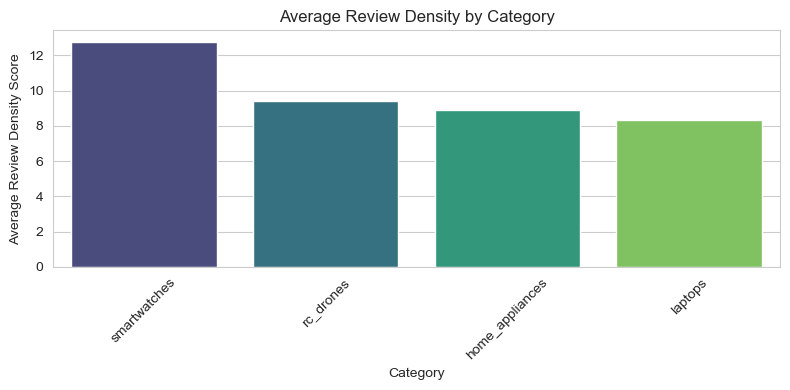

In [64]:
## 4. Best Value Metric per Category (Review Density)
print("\n--- 4. Top Value Products (Highest Review Density) per Category ---")

# Category ke hisaab se highest review_density wale products nikalna
def get_top_n_value(group, n=3):
    return group.sort_values(by='review_density', ascending=False).head(n)

top_value_products = df_final.groupby('category').apply(get_top_n_value).reset_index(drop=True)

# Top value products ka table print karna
print(top_value_products[['category', 'product_name', 'price', 'rating', 'review_density']])

# Visualization (optional): Aggregate average Review Density per Category
plt.figure(figsize=(8, 4))
avg_density = df_final.groupby('category')['review_density'].mean().sort_values(ascending=False)
sns.barplot(x=avg_density.index, y=avg_density.values, palette='viridis')
plt.title('Average Review Density by Category')
plt.xlabel('Category')
plt.ylabel('Average Review Density Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ***Analysis 5: Category-wise Product Count (Bar Chart)***


--- 5. Product Count per Category ---


C:\Users\Hp Probook\AppData\Local\Temp\ipykernel_13720\3904556059.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='plasma')


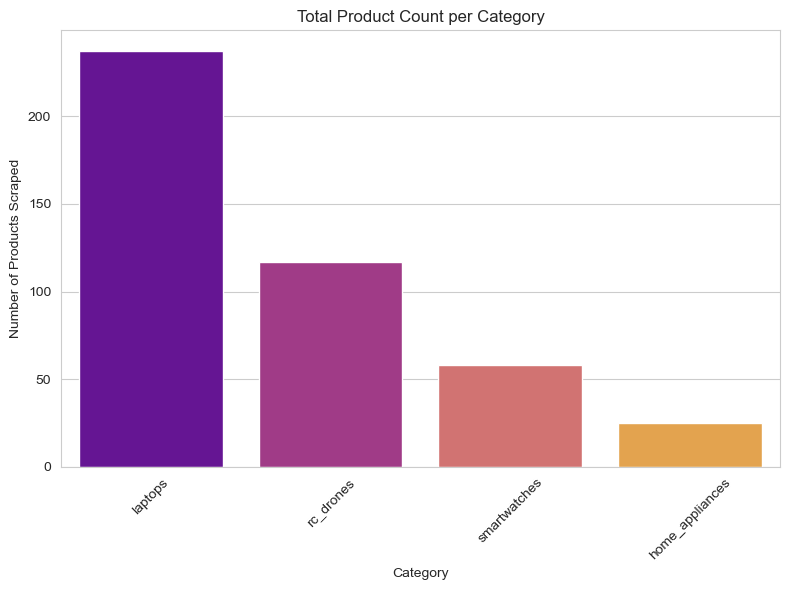


Total Product Count:
 category
laptops            237
rc_drones          117
smartwatches        58
home_appliances     25
Name: count, dtype: int64


In [63]:
## 5. Category-wise Product Count
print("\n--- 5. Product Count per Category ---")

category_counts = df_final['category'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='plasma')
plt.title('Total Product Count per Category')
plt.xlabel('Category')
plt.ylabel('Number of Products Scraped')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTotal Product Count:\n", category_counts)

In [ ]:
# Final cleaned data ko CSV file mein save karna
output_file_path = folder_path + r'\banggood_products_cleaned_final.csv'
df_final.to_csv(output_file_path, index=False)

print(f"\n✅ Data successfully saved to: {output_file_path}")


✅ Data successfully saved to: E:\cde\CDE_HACATHON\data\raw\banggood_products_cleaned_final.csv
